# Deep Learning - Transfer Learning

In [1]:
import torch
import copy
from torchvision import models
import time
import numpy as np
from pathlib import Path
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score

In [2]:
folder = Path('C:\\Users\\siddh\\Documents\\UTD\\BUAN 6v99 - DeepLearning\\HW4')

In [3]:
torch.manual_seed(0)
# define transformation
data_transformer = transforms.Compose([transforms.ToTensor()])
    
# loading data
train_ds = datasets.CIFAR10(folder, train=True, transform=data_transformer, download=True)
# print out data shape
print(train_ds.data.shape)

Files already downloaded and verified
(50000, 32, 32, 3)


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: C:\Users\siddh\Documents\UTD\BUAN 6v99 - DeepLearning\HW4
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
import collections

# get labels
y_train=[y for _,y in train_ds]

# count labels
counter_train=collections.Counter(y_train)
print(counter_train)

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [5]:
# loading data
test0_ds = datasets.CIFAR10(folder, train=False, transform=data_transformer, download=True)
print(test0_ds.data.shape)

Files already downloaded and verified
(10000, 32, 32, 3)


## Next, split the indices of test0_ds into two groups:

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=list(range(len(test0_ds)))
y_test0=[y for _,y in test0_ds]
for test_index, val_index in sss.split(indices, y_test0):
    print("test:", test_index, "val:", val_index)
    print(len(val_index),len(test_index))

test: [5278 3265  795 ...  712  139 5732] val: [5712 7359  919 ... 3641  142 6090]
2000 8000


## Create Validation and test dataset

In [7]:
from torch.utils.data import Subset

val_ds=Subset(test0_ds,val_index)
test_ds=Subset(test0_ds,test_index)

## count the number of images per class in val_ds and test_ds

In [8]:
import collections
import numpy as np

# get labels
y_test=[y for _,y in test_ds]
y_val=[y for _,y in val_ds]

counter_test=collections.Counter(y_test)
counter_val=collections.Counter(y_val)

print(counter_test)
print(counter_val)

Counter({0: 800, 8: 800, 7: 800, 6: 800, 3: 800, 1: 800, 4: 800, 2: 800, 5: 800, 9: 800})
Counter({2: 200, 1: 200, 0: 200, 6: 200, 9: 200, 4: 200, 3: 200, 5: 200, 8: 200, 7: 200})


##  Show a few sample images from train_ds

image indices: [ 2732 43567 42613 45891]
torch.Size([3, 36, 138])


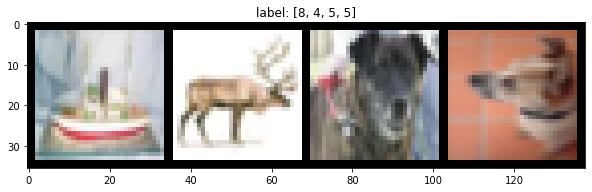

In [9]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

## Show a few sample images from val_ds

image indices: [ 684  559 1653 1216]
torch.Size([3, 36, 138])


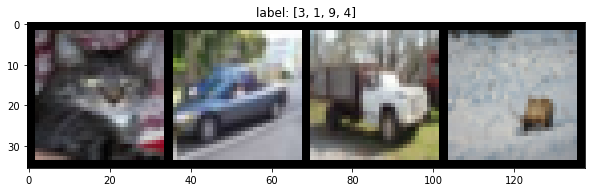

In [10]:
np.random.seed(0)

grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[val_ds[i][0] for i in rnd_inds]
y_grid=[val_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

## Calculate the mean and standard deviation of train_ds

In [11]:
# RGB mean and std 
meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

0.49139965 0.48215845 0.4465309
0.20220213 0.19931543 0.20086348


## Data Transformation

For test0_ds, we only added the normalization function since we do not require data augmentation for the validation and test datasets

In [12]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])])
                 

test0_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
    ])  

In [13]:
# overwrite the transform functions
# Note that when we update the test0_ds.transform function, both val_ds, 
# and test_ds will be updated since they are subsets of test0_ds.
train_ds.transform=train_transformer
test0_ds.transform=test0_transformer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [ 2732 43567 42613 45891]
torch.Size([3, 36, 138])


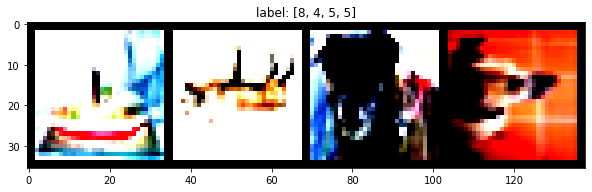

In [14]:
np.random.seed(0)
torch.manual_seed(0)

# make a grid
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [15]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)  

In [16]:
# extract a batch from training data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [17]:
# extract a batch from validation data
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [18]:
# A helper function to count the number of correct predictions per data batch:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [19]:
# A helper function to compute the loss value per batch of data:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [20]:
# a helper function to compute the loss value and the performance metric for the entire dataset or an epoch.

# define device as a global variable
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    device = torch.device("cuda")
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [21]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [22]:
def deploy_model(model,dataset,device, num_classes=10,sanity_check=False):

    len_data=len(dataset)
    
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data,num_classes)
    
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data),dtype="uint8")
    
    # move model to device
    model=model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time.time()    
            yy=model(x.unsqueeze(0).to(device))
            y_out[i]=torch.softmax(yy,dim=1)
            elapsed=time.time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device,inference_time))
    return y_out.numpy(),y_gt

In [23]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Creating models

### Task 1:  Unfreeze only the classifier layer. Make appropriate changes to adapt this to CIFAR-10.

### Load a pre-trained vgg16 model

In [24]:
# load model with pretrained weights
vgg16_pretrained = models.vgg16(pretrained=True)

# Freeze training for all layers
for param in vgg16_pretrained.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
class_names = train_ds.classes
num_features = vgg16_pretrained.classifier[6].in_features
features = list(vgg16_pretrained.classifier.children())[:-1] # Remove last layer

extra_layer = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=512, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(in_features=512, out_features=len(class_names), bias=True),
    nn.LogSoftmax()
    )

features.extend([extra_layer]) # Add our layer with 4 outputs
vgg16_pretrained.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16_pretrained)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
device = torch.device("cuda:0")
vgg16_pretrained.to(device) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
# Even though the original image sizes are 96*96, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(vgg16_pretrained, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

### Let's visualize the filters of the first CNN layer:

torch.Size([64, 3, 3, 3])
0.0 0.9217420220375061
torch.Size([3, 33, 33])


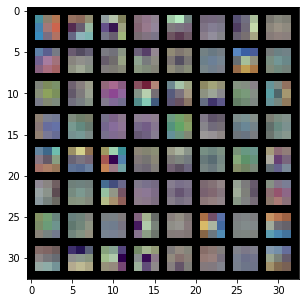

In [27]:
# get Conv1 weights
for w in vgg16_pretrained.parameters():
    w=w.data.cpu()
    print(w.shape)
    break

# normalize to [0,1]
min_w=torch.min(w)
w1 = (-1/(2*min_w))*w + 0.5 
print(torch.min(w1).item(),torch.max(w1).item())

# make a grid
grid_size=len(w1)
x_grid=[w1[i] for i in range(grid_size)]
x_grid=utils.make_grid(x_grid, nrow=8, padding=1)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(5,5))
show(x_grid)

### Define Loss Function and Optimizer

In [28]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(vgg16_pretrained.parameters(), lr=1e-4)

In [29]:
current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0001


In [30]:
# define learning rate scheduler
# Several methods exist to adjust the learning rate. For a list of supported methods by PyTorch, 
# please visit the following link: https://pytorch.org/docs/stable/optim.html.
lr_scheduler = CosineAnnealingLR(opt,T_max=2,eta_min=1e-5)

In [31]:
lrs=[]
for i in range(10):
    lr_scheduler.step()
    lr=get_lr(opt)
    print("epoch %s, lr: %.1e" %(i,lr))
    lrs.append(lr)

epoch 0, lr: 5.5e-05
epoch 1, lr: 1.0e-05
epoch 2, lr: 5.5e-05
epoch 3, lr: 1.0e-04
epoch 4, lr: 5.5e-05
epoch 5, lr: 1.0e-05
epoch 6, lr: 5.5e-05
epoch 7, lr: 1.0e-04
epoch 8, lr: 5.5e-05
epoch 9, lr: 1.0e-05


C:\Users\siddh\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


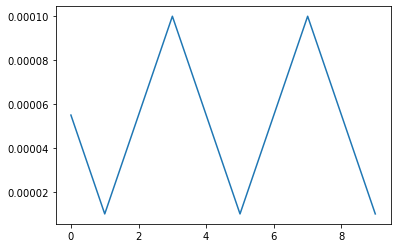

In [32]:
plt.plot(lrs)

### Training and Transfer Learning

### Train With Pre-Trained Weights

In [33]:
# opt = optim.Adam([vgg16_pretrained.classifier[0].parameters(), lr=1e-4,
#             vgg16_pretrained.features.parameters(), lr=1e-3])

In [34]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(vgg16_pretrained.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 10,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "vgg16_pretrained.pt",
}

# train and validate the model
vgg16_pretrained,loss_hist,metric_hist=train_val(vgg16_pretrained,params_train)

Epoch 0/9, current lr=0.0001


C:\Users\siddh\anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Copied best model weights!
train loss: 0.939950, dev loss: 0.653657, accuracy: 78.70
----------
Epoch 1/9, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.597555, dev loss: 0.542885, accuracy: 81.30
----------
Epoch 2/9, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.443750, dev loss: 0.521449, accuracy: 83.35
----------
Epoch 3/9, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.324187, dev loss: 0.450716, accuracy: 84.45
----------
Epoch 4/9, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.243020, dev loss: 0.423838, accuracy: 86.40
----------
Epoch 5/9, current lr=1e-06
Copied best model weights!
train loss: 0.215661, dev loss: 0.416524, accuracy: 86.85
----------
Epoch 6/9, current lr=1.0453658778440102e-05
train loss: 0.215960, dev loss: 0.428576, accuracy: 86.75
----------
Epoch 7/9, current lr=3.520365877844009e-05
train loss: 0.247301, dev loss: 0.445213, accuracy: 86.25
------

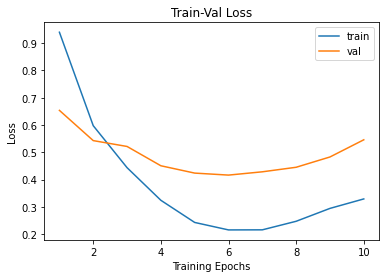

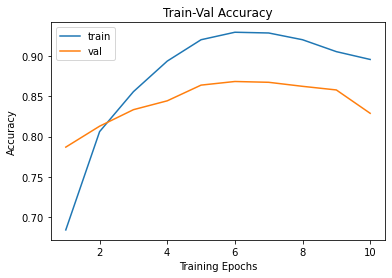

In [35]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

### Deploy Model

In [36]:
# load state_dict into model
path2weights=folder / "vgg16_pretrained.pt"
vgg16_pretrained.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [37]:
# set model in evaluation mode
vgg16_pretrained.eval();

In [38]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    vgg16_pretrained=vgg16_pretrained.to(device)

In [39]:
# deploy model 
y_out,y_gt=deploy_model(vgg16_pretrained,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 4.59 ms 
(2000, 10) (2000,)


In [40]:
# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)

# compute accuracy 
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

(2000,) (2000,)
accuracy: 0.87


In [41]:
y_out,y_gt=deploy_model(vgg16_pretrained,test_ds,device=device)
y_pred = np.argmax(y_out,axis=1)
acc=accuracy_score(y_pred,y_gt)
print(acc)

average inference time per image on cuda: 4.59 ms 
0.8785


### Unfreeze and train on LAST CNN block onwards (i.e. features [24] and onwards).

In [24]:
# load model with pretrained weights
vgg16_pretrained_2 = models.vgg16(pretrained=True)
vgg16_pretrained_2

# Freeze training for layers till 23 inclusive
for param in vgg16_pretrained_2.features[0:24].parameters():
    param.require_grad = False

# UnFreeze training for layers 24 and onward
for param in vgg16_pretrained_2.features[24:].parameters():
    param.require_grad = True

# Newly created modules have require_grad=True by default
class_names = train_ds.classes
num_features = vgg16_pretrained_2.classifier[6].in_features
features = list(vgg16_pretrained_2.classifier.children())[:-1] # Remove last layer

extra_layer = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=512, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(in_features=512, out_features=len(class_names), bias=True),
    nn.LogSoftmax()
    )

features.extend([extra_layer]) # Add our layer with 4 outputs
vgg16_pretrained_2.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16_pretrained_2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
device = torch.device("cuda:0")
vgg16_pretrained_2.to(device) 

# Even though the original image sizes are 96*96, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(vgg16_pretrained_2, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

In [26]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(vgg16_pretrained_2.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 15,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "vgg16_pretrained_2.pt",
}

# train and validate the model
vgg16_pretrained_2,loss_hist,metric_hist=train_val(vgg16_pretrained_2,params_train)

Epoch 0/14, current lr=0.0001


C:\Users\siddh\anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Copied best model weights!
train loss: 0.936496, dev loss: 0.740748, accuracy: 76.10
----------
Epoch 1/14, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.597485, dev loss: 0.598804, accuracy: 79.40
----------
Epoch 2/14, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.445510, dev loss: 0.579912, accuracy: 80.40
----------
Epoch 3/14, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.321730, dev loss: 0.434998, accuracy: 85.20
----------
Epoch 4/14, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.242726, dev loss: 0.427971, accuracy: 85.95
----------
Epoch 5/14, current lr=1e-06
Copied best model weights!
train loss: 0.209478, dev loss: 0.422991, accuracy: 86.75
----------
Epoch 6/14, current lr=1.0453658778440102e-05
train loss: 0.209720, dev loss: 0.428980, accuracy: 86.10
----------
Epoch 7/14, current lr=3.520365877844009e-05
train loss: 0.243223, dev loss: 0.480336, accuracy: 85.25

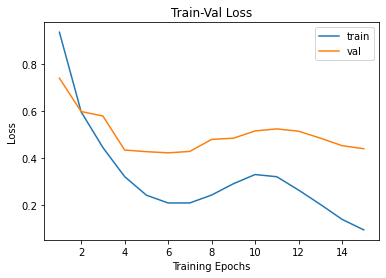

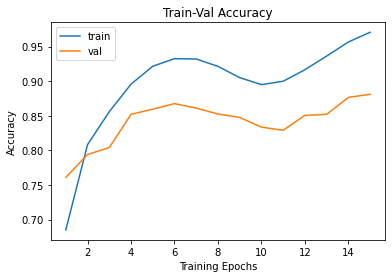

In [27]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [28]:
# load state_dict into model
path2weights=folder / "vgg16_pretrained_2.pt"
vgg16_pretrained_2.load_state_dict(torch.load(path2weights))

# set model in evaluation mode
vgg16_pretrained_2.eval();

# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    vgg16_pretrained_2=vgg16_pretrained_2.to(device)

# deploy model 
y_out,y_gt=deploy_model(vgg16_pretrained_2,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)



average inference time per image on cuda: 4.62 ms 
(2000, 10) (2000,)


In [29]:
# get predictions for train
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

# get predictions for test
y_out,y_gt=deploy_model(vgg16_pretrained_2,test_ds,device=device)
y_pred = np.argmax(y_out,axis=1)
acc=accuracy_score(y_pred,y_gt)
print(acc)

(2000,) (2000,)
accuracy: 0.87
average inference time per image on cuda: 4.69 ms 
0.875875


### Unfreeze and train on LAST two CNN block onwards (i.e. features [17] and onwards).

In [26]:
# load model with pretrained weights
vgg16_pretrained_3 = models.vgg16(pretrained=True)
vgg16_pretrained_3

# Freeze training for layers till 23 inclusive
for param in vgg16_pretrained_3.features[0:18].parameters():
    param.require_grad = False

# UnFreeze training for layers 24 and onward
for param in vgg16_pretrained_3.features[18:].parameters():
    param.require_grad = True

# Newly created modules have require_grad=True by default
class_names = train_ds.classes
num_features = vgg16_pretrained_3.classifier[6].in_features
features = list(vgg16_pretrained_3.classifier.children())[:-1] # Remove last layer

extra_layer = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=512, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(in_features=512, out_features=len(class_names), bias=True),
    nn.LogSoftmax()
    )

features.extend([extra_layer]) # Add our layer with 4 outputs
vgg16_pretrained_3.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16_pretrained_3)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
device = torch.device("cuda:0")
vgg16_pretrained_3.to(device) 

# Even though the original image sizes are 96*96, we need to resize them to 224*224, 
# the same size that the resnet18 model was trained at.
from torchsummary import summary
summary(vgg16_pretrained_3, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

In [28]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(vgg16_pretrained_3.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 15,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "vgg16_pretrained_3.pt",
}

# train and validate the model
vgg16_pretrained_3,loss_hist,metric_hist=train_val(vgg16_pretrained_3,params_train)

Epoch 0/14, current lr=0.0001


C:\Users\siddh\anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Copied best model weights!
train loss: 0.945505, dev loss: 0.723054, accuracy: 76.45
----------
Epoch 1/14, current lr=9.05463412215599e-05
Copied best model weights!
train loss: 0.599007, dev loss: 0.654905, accuracy: 79.65
----------
Epoch 2/14, current lr=6.57963412215599e-05
Copied best model weights!
train loss: 0.442978, dev loss: 0.545427, accuracy: 82.15
----------
Epoch 3/14, current lr=3.52036587784401e-05
Copied best model weights!
train loss: 0.323324, dev loss: 0.444338, accuracy: 84.30
----------
Epoch 4/14, current lr=1.0453658778440105e-05
Copied best model weights!
train loss: 0.244560, dev loss: 0.424376, accuracy: 85.90
----------
Epoch 5/14, current lr=1e-06
Copied best model weights!
train loss: 0.216211, dev loss: 0.414866, accuracy: 86.70
----------
Epoch 6/14, current lr=1.0453658778440102e-05
train loss: 0.217042, dev loss: 0.429802, accuracy: 86.05
----------
Epoch 7/14, current lr=3.520365877844009e-05
train loss: 0.246201, dev loss: 0.453971, accuracy: 85.60

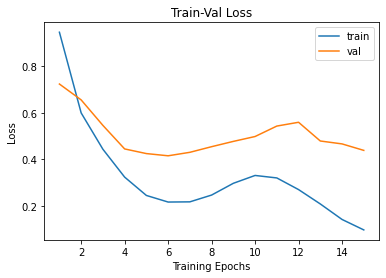

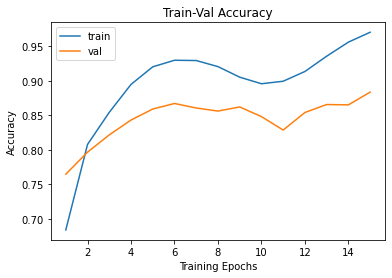

In [29]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [31]:
# load state_dict into model
path2weights=folder / "vgg16_pretrained_3.pt"
vgg16_pretrained_3.load_state_dict(torch.load(path2weights))

# set model in evaluation mode
vgg16_pretrained_3.eval();

# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    vgg16_pretrained_3=vgg16_pretrained_3.to(device)

# deploy model 
y_out,y_gt=deploy_model(vgg16_pretrained_3,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 4.47 ms 
(2000, 10) (2000,)


In [32]:
# get predictions for train
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

# get predictions for test
y_out,y_gt=deploy_model(vgg16_pretrained_3,test_ds,device=device)
y_pred = np.argmax(y_out,axis=1)
acc=accuracy_score(y_pred,y_gt)
print(acc)

(2000,) (2000,)
accuracy: 0.87
average inference time per image on cuda: 4.43 ms 
0.88025


### Observation: Unfreezing more layers increased the accuracy of test dataset

### Exploring use of different learning rates for different layers in each epoch

In [24]:
# load model with pretrained weights
vgg16_pretrained_4 = models.vgg16(pretrained=True)

# Freeze training for all layers
for param in vgg16_pretrained_4.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
class_names = train_ds.classes
num_features = vgg16_pretrained_4.classifier[6].in_features
features = list(vgg16_pretrained_4.classifier.children())[:-1] # Remove last layer

extra_layer = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=512, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(in_features=512, out_features=len(class_names), bias=True),
    nn.LogSoftmax()
    )

features.extend([extra_layer]) # Add our layer with 4 outputs
vgg16_pretrained_4.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16_pretrained_4)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
device = torch.device("cuda:0")
vgg16_pretrained_4.to(device) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam([
    {"params": vgg16_pretrained_4.features.parameters(), 'lr' : 1e-5, "momentum" : 0.99},
    {"params": vgg16_pretrained_4.classifier.parameters(),'lr' : 1e-4, "momentum" : 0.99}])
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 5,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": folder / "vgg16_pretrained_4.pt",
}

# train and validate the model
vgg16_pretrained_4,loss_hist,metric_hist=train_val(vgg16_pretrained_4,params_train)

Epoch 0/4, current lr=1e-05


C:\Users\siddh\anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Copied best model weights!
train loss: 1.009731, dev loss: 0.758255, accuracy: 74.65
----------
Epoch 1/4, current lr=9.140576474687265e-06
Copied best model weights!
train loss: 0.715877, dev loss: 0.680374, accuracy: 76.30
----------
Epoch 2/4, current lr=6.890576474687264e-06
Copied best model weights!
train loss: 0.602551, dev loss: 0.616742, accuracy: 78.15
----------
Epoch 3/4, current lr=4.109423525312737e-06
Copied best model weights!
train loss: 0.517992, dev loss: 0.568900, accuracy: 79.85
----------
Epoch 4/4, current lr=1.8594235253127369e-06
Copied best model weights!
train loss: 0.459631, dev loss: 0.568203, accuracy: 80.65
----------


In [29]:
# load state_dict into model
path2weights=folder / "vgg16_pretrained_4.pt"
vgg16_pretrained_4.load_state_dict(torch.load(path2weights))

# set model in evaluation mode
vgg16_pretrained_4.eval();

# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    vgg16_pretrained_4=vgg16_pretrained_4.to(device)

# deploy model 
y_out,y_gt=deploy_model(vgg16_pretrained_4,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 4.43 ms 
(2000, 10) (2000,)


In [31]:
# get predictions for train
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

# get predictions for test
y_out,y_gt=deploy_model(vgg16_pretrained_4,test_ds,device=device)
y_pred = np.argmax(y_out,axis=1)
acc=accuracy_score(y_pred,y_gt)
print(acc)

(2000,) (2000,)
accuracy: 0.81
average inference time per image on cuda: 4.43 ms 
0.817125
